# __FINAL PROJECT PHASE IV__

### Table of Contents
1. Introduction <br>
    a. Background and Context <br>
    b. Research Question <br>
    c. Data Collection and Cleaning Summary <br>
2. Data Description<br>
3. Preregistration Statement<br>
4. Data Analysis <br>
    a. Data Exploration <br>
    b. Research Question Models<br>
       - Evaluation of Significance<br>
       - Interpretation and Conclusions<br>
5. Limitations<br>
6. Source Code<br>
7. Acknowledgements<br>

# 1. Introduction 

### a. Background and Context

In this project, we examined the dynamics of the FIFA World Cup, specifically in seeking to understand how the pressure of the tournament's progression impacts the nature of play. By analyzing the dataset of match statistics, we focus on expected goals (xG) to infer whether the transition from group stage to knockout rounds influences the attacking intensity of the teams. The ability to predict match outcomes through such statistical measures is not just compelling for its application in sports analytics but also as a reflection of human behavior in competitive scenarios. 

By pairing the dataset with robust statistical methods, we aim to investigate the strategic adaptations and team performance. The findings from our study have the potential to contribute to a more nuanced understanding of football tactics and to spark further study into the effects of psychological and environmental factors on high-level competition.

### b. Research Question:
Question: What are the most influential statistical indicators for predicting the outcomes of FIFA World Cup matches, and how does their predictive accuracy vary across different tournament stages such as group matches, knockout rounds, and the final?

**Rationale:**

We aim to investigate the key statistical indicators that significantly influence the outcomes of FIFA World Cup matches. We are particularly interested in understanding how these indicators contribute to predicting match outcomes at various stages of the tournament, including group matches, knockout rounds, and the final. By identifying and analyzing these influential indicators, we intend to enhance our understanding of the factors that play a crucial role in determining match results throughout the different phases of this prestigious football event.

In [2]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn import preprocessing

from scipy import stats

In [3]:
#read csv
wc_df = pd.read_csv("./wc_2022.csv", encoding='unicode_escape')
wc_df.head()

,match_no,day_of_week,date,hour,venue,referee,group,1,2,attendance,...,1_panelties_scored,2_panelties_scored,1_goal_prevented,2_goal_prevented,1_own_goal,2_own_goal,1_forced_turnovers,2_forced_turnovers,1_defensive_pressure_applied,2_defensive_pressure_applied
0,1,Sun,20-Nov-22,17:00,Al Bayt Stadium,Daniele Orsato,Group A,QATAR,ECUADOR,67372,...,0,1,6,5,0,0,52,72,256,279
1,2,Mon,21-Nov-22,14:00,Khalifa International Stadium,Raphael Claus,Group B,ENGLAND,IRAN,45334,...,0,1,8,13,0,0,63,72,139,416
2,3,Mon,21-Nov-22,17:00,Al Thumama Stadium,Wilton Sampaio,Group A,SENEGAL,NETHERLANDS,41721,...,0,0,9,15,0,0,63,73,263,251
3,4,Mon,21-Nov-22,20:00,Ahmed bin Ali Stadium,Abdulrahman Ibrahim Al Jassim,Group B,UNITED STATES,WALES,43418,...,0,1,7,7,0,0,81,72,242,292
4,5,Tue,22-Nov-22,11:00,Lusail Iconic Stadium,Slavko Vincic,Group C,ARGENTINA,SAUDI ARABIA,88012,...,1,0,4,14,0,0,65,80,163,361


### c. Data Filtering and Column Concatenation

In this section, we perform data preprocessing to prepare our dataset for analysis. Specifically, we remove irrelevant columns and concatenate two existing columns into a new one.

1. **Removing Irrelevant Columns:**
   - We eliminate the following columns from the dataset:
     - `day_of_week`: This information is not needed for our analysis.
     - `hour`: The hour of the match is not relevant to our current study.
     - `referee`: The referee's name is not a focus of our analysis.
     - `1_forced_turnovers`: This column is not necessary for our current analysis.
     - `2_forced_turnovers`: Similarly, this column is not required for our analysis.

2. **Concatenating Columns:**
   - We create a new column called "Match," which combines the content of "team in 1" and "team in 2." This column will represent each match as "team in 1 vs. team in 2."

These data preparation steps ensure that our dataset is streamlined and ready for the analysis phase.


In [4]:
# Remove specified columns and create a new 'Match' column
clean_df = wc_df.drop(columns=['day_of_week', 'hour', \
                               'referee', '1_forced_turnovers', \
                               '2_forced_turnovers'])
conc_col = clean_df['1'] + ' vs ' + clean_df['2']

# conc_col=conc_col.to_list()
clean_df.insert(loc = 4,
          column = 'match',
          value = conc_col)

print(clean_df.shape)

#insert a column for the winner of each match, first create 
def calculate_result(row):
    """
    Determine the result of a soccer match based on goal difference.
    
    Parameters:
    - row (pd.Series): A row from clean_df containing '1_goals' and '2_goals'.
    
    Returns:
    - str: The result of the match. It can be one of three values:
      - Team 1's name, if team 1 wins.
      - Team 2's name, if team 2 wins.
      - 'Draw', if the match is a tie.
      """
    diff = row['1_goals'] - row['2_goals']
    if diff < 0:
        return row['2']
    elif diff > 0:
        return row['1']
    else:
        return 'Draw'

clean_df['Result'] = clean_df.apply(calculate_result, axis=1)

#replace some draw in games with results from penalty shoot-out,  
#first create a dictionary of matches with the shoot-out winners
shoot_out_winners = {
    'JAPAN vs CROATIA': 'CROATIA',
    'MOROCCO vs SPAIN': 'MOROCCO',
    'CROATIA vs BRAZIL': 'CROATIA',
    'NETHERLANDS vs ARGENTINA': 'ARGENTINA',
    'ARGENTINA vs FRANCE': 'ARGENTINA'}

#update the 'Result' column based on the shoot-out results
for match, winner in shoot_out_winners.items():
    match_condition = (clean_df['match'] == match) & (clean_df['Result'] == 'Draw')
    clean_df.loc[match_condition, 'Result'] = winner

#print updated results to check if the shoot-out winners are updated
print(clean_df[clean_df['match'].isin(shoot_out_winners.keys())][['match', 'Result']])



(64, 55)
                       match     Result
52          JAPAN vs CROATIA    CROATIA
54          MOROCCO vs SPAIN    MOROCCO
56         CROATIA vs BRAZIL    CROATIA
57  NETHERLANDS vs ARGENTINA  ARGENTINA
63       ARGENTINA vs FRANCE  ARGENTINA


3. **Grouping Teams into Stages**
- We group the columns by different stages of the World Cup with goals attempted and shots ontarget in order to showcase the frequnecy attempts and precision of the attempts in each match throughout the game

In [5]:
duckdb.sql(
"""
SELECT "group", "match", "1_attempts", "2_attempts", "1_ontarget", "2_ontarget"
FROM clean_df
ORDER BY "group"
""").df()

,group,match,1_attempts,2_attempts,1_ontarget,2_ontarget
0,Final,ARGENTINA vs FRANCE,21,10,9,5
1,Group A,NETHERLANDS vs QATAR,13,6,4,4
2,Group A,SENEGAL vs NETHERLANDS,14,9,3,3
3,Group A,QATAR vs ECUADOR,5,6,0,3
4,Group A,ECUADOR vs SENEGAL,8,15,4,5
...,...,...,...,...,...,...
59,Round of 16,FRANCE vs POLAND,16,11,7,3
60,Round of 16,NETHERLANDS vs UNITED STATES,11,18,6,7
61,Round of 16,ARGENTINA vs AUSTRALIA,14,5,5,2
62,Semi-Final,ARGENTINA vs CROATIA,10,12,7,3


# 2. Data Description: 2022 World Cup Results Dataset

#### What are the observations (rows) and the attributes (columns)?
- **Observations (rows)**: 
  - Each observation represents a unique match from the 2022 World Cup.
- **Attributes (columns)**:
  - The dataset details the match number, day of the week, date, hour, venue, referee, group, and various statistics related to the performance of both teams.

#### Why was this dataset created?
- The dataset was created to capture detailed statistics and results of each match during the 2022 World Cup for potential insights into team performances, game dynamics, and other tournament aspects.

#### Who funded the creation of the dataset?
- Technique used for data collection is web scrapping and was done by Shrikrishna Parab.

#### What processes might have influenced what data was observed and recorded and what was not?
  - Significance of specific statistics in understanding a football match.
  - Availability and accuracy of technology for tracking specific statistics.
  - Demand from stakeholders (e.g., coaches, teams, analysts) for specific data.

#### What preprocessing was done, and how did the data come to be in the form that you are using?
  - Preprocessing steps:
  - Data cleaning to handle inaccuracies.
  - Data normalization
  - Aggregating data from multiple sources.
  - Handling missing data or imputing values.

#### If people are involved, were they aware of the data collection, and what purpose did they expect the data to be used for?
- In professional football, players and coaches typically expect data collection for performance analysis, broadcasting insights, and public dissemination.

#### Where can your raw source data be found, if applicable?
- Data can be found on Github https://github.com/shreeparab1890/Fifa-WC-2022-Qatar-Data-Analysis-EDA/blob/main/Fifa_WC_2022_Match_data.csv

# Dataset Column Descriptions:

1. `match_no`: Match number in the tournament.
2. `day_of_week`: Day of the week when the match took place.
3. `date`: Date of the match.
4. `hour`: Time of day when the match started.
5. `venue`: Location where the match was held.
6. `referee`: Name of the referee officiating the match.
7. `group`: Group of teams to which the match belongs.
8. `1`: Team 1 identifier or name.
9. `2`: Team 2 identifier or name.
10. `attendance`: Number of spectators present at the match.
11. `1_xg`: Expected goals for Team 1.
12. `2_xg`: Expected goals for Team 2.
13. `1_poss`: Possession percentage for Team 1.
14. `2_poss`: Possession percentage for Team 2.
15. `1_goals`: Goals scored by Team 1.
16. `2_goals`: Goals scored by Team 2.
17. `score`: Final score of the match.
18. `1_attempts`: Total attempts by Team 1.
19. `2_attempts`: Total attempts by Team 2.
20. `1_conceded`: Goals conceded by Team 1.
21. `2_conceded`: Goals conceded by Team 2.
22. `1_goal_inside_penalty_area`: Goals scored by Team 1 from inside the penalty area.
23. `2_goal_inside_penalty_area`: Goals scored by Team 2 from inside the penalty area.
24. `1_goal_outside_penalty_area`: Goals scored by Team 1 from outside the penalty area.
25. `2_goal_outside_penalty_area`: Goals scored by Team 2 from outside the penalty area.
26. `1_ontarget`: On-target attempts by Team 1.
27. `2_ontarget`: On-target attempts by Team 2.
28. `1_offtarget`: Off-target attempts by Team 1.
29. `2_offtarget`: Off-target attempts by Team 2.
30. `1_attempts_inside_penalty_area`: Attempts by Team 1 inside the penalty area.
31. `2_attempts_inside_penalty_area`: Attempts by Team 2 inside the penalty area.
32. `1_attempts_outside_penalty_area`: Attempts by Team 1 outside the penalty area.
33. `2_attempts_outside_penalty_area`: Attempts by Team 2 outside the penalty area.
34. `1_yellow_cards`: Yellow cards received by Team 1.
35. `2_yellow_cards`: Yellow cards received by Team 2.
36. `1_red_cards`: Red cards received by Team 1.
37. `2_red_cards`: Red cards received by Team 2.
38. `faul_against_1`: Number of fouls against Team 1.
39. `faul_against_2`: Number of fouls against Team 2.
40. `1_offsides`: Offsides committed by Team 1.
41. `2_offsides`: Offsides committed by Team 2.
42. `1_passes`: Total passes made by Team 1.
43. `2_passes`: Total passes made by Team 2.
44. `1_passes_compeletd`: Total passes completed by Team 1.
45. `2_passes_compeletd`: Total passes completed by Team 2.
46. `1_corners`: Total corner kicks awarded to Team 1.
47. `2_corners`: Total corner kicks awarded to Team 2.
48. `1_free_kicks`: Total free kicks awarded to Team 1.
49. `2_free_kicks`: Total free kicks awarded to Team 2.
50. `1_panelties_scored`: Penalties scored by Team 1.
51. `2_panelties_scored`: Penalties scored by Team 2.
52. `1_goal_prevented`: Goals prevented by Team 1 (e.g., by goalkeeper or defense).
53. `2_goal_prevented`: Goals prevented by Team 2 (e.g., by goalkeeper or defense).
54. `1_own_goal`: Own goals scored by Team 1.
55. `2_own_goal`: Own goals scored by Team 2.
56. `1_forced_turnovers`: Forced turnovers by Team 1. Forced turnovers indicate instances where possession is lost as a result of pressure from an opposing player.
57. `2_forced_turnovers`: Forced turnovers by Team 2. Forced turnovers indicate instances where possession is lost as a result of pressure from an opposing player.
58. `1_defensive_pressure_applied`: Defensive pressure applied by Team 1.
59. `2_defensive_pressure_applied`: Defensive pressure applied by Team 2.
60. `Result`: Winning country in each match. If the game ended in a draw, the value is “Draw”.
61. `1_pass_success`: Proportion of successful passes from total number of passes for Team 1.
62. `2_pass_success`: Proportion of successful passes from total number of passes for Team 2.
63. `winning_pass_success`: The pass success rate of the winning team.
64. `match`: The two countries competing in the game.
65. `Team_1_Goals_Diff`: The goals of Team 1 minus their expected goals.
66. `Team_2_Goals_Diff`: The goals of Team 2 minus their expected goals.


# 3. Preregistration statements

- **Hypothesis 1**: Higher possession statistics (e.g., `1_poss` and `2_poss`) predict the match outcomes
- **Analysis**: Use a logistic regression model to analyze the effect of possession percentages (`1_poss` and `2_poss`) on match outcomes (`Result`). This analysis will be performed across matches, and the strength and significance of the possession coefficients in each of these stages will be compared to determine if their influence varies across matches.


- **Hypothesis 2**: Matches in the knockout stages (Quarter-final, Semi-Final, and Final) have a higher average xG (expected goals) value for teams, indicating that these matches are more aggressive in nature as compared to the group stages.
- **Analysis**: To determine whether knockout stage matches in the World Cup are more attack-oriented, we'll compare their average expected goals (xG) to those in group stage matches. By using a t-test, we'll check for a statistically significant difference. If our p-value falls below 0.05 (we use an alpha level of 5%), it suggests knockout matches might indeed be more aggressive.


# 4. Data Analysis

### a. Data explorations 

In this section we explored some interesting ways to evaluate the 2022 World Cup, including calculating the average possession per team in each match, the ranking of goals scored by each nation throughout the stage, the passing success rate of each team, team's actual performance vs. their expected goals, yellow cards, and red cards of the teams throughout the match. The purpose of these explorations is to give us inspirations on how to proceed with more refined analysis later on. 

### 1: Calculating the average possession

<built-in function all>


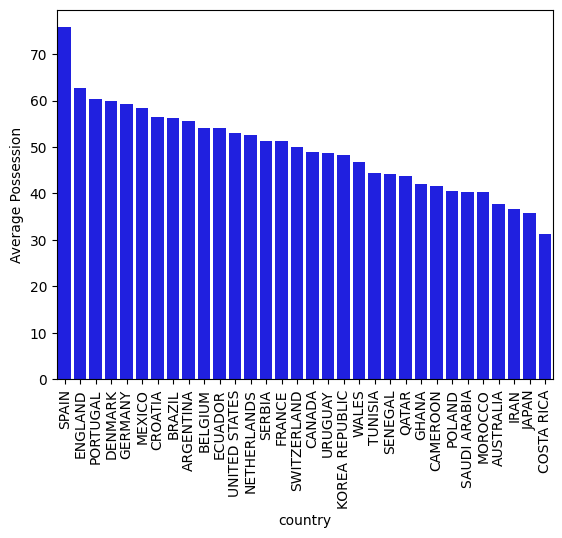

In [6]:
#got all the games in the home
home = duckdb.sql("""
    SELECT DISTINCT  "1_poss" AS "possession", "1" AS "country"
    FROM wc_df
""").df()
#got all the games in the away
away = duckdb.sql("""  SELECT DISTINCT "2_poss" AS "possession" ,"2" AS "country"
    FROM wc_df
 """).df()

#combining both of the data frames in order to calculate 
games= pd.concat([home, away])
print(all)

Average_possesion = duckdb.sql("""select AVG(possession) AS "Average Possession", country 
           from games
           group by "country"
           order by "Average Possession" desc """).df()
sns.barplot(Average_possesion ,x="country", y="Average Possession", color="b")
plt.xticks(rotation=90)
plt.show()

### 2: Ranking the total goals scored by each country throughout the stages

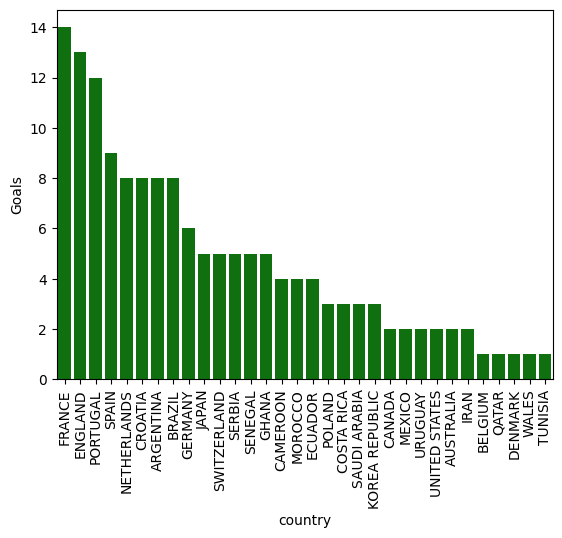

In [7]:
#got all the games in the home
home_goals = duckdb.sql("""
    SELECT DISTINCT  "1_goals" AS "goals", "1" AS "country"
    FROM wc_df
""").df()

#got all the games in the away
away_goals = duckdb.sql("""  SELECT DISTINCT "2_goals" AS "goals" ,"2" AS "country"
    FROM wc_df
 """).df()

#combining both of the data frames in order to calculate 
goals= pd.concat([home_goals, away_goals])

total_goals = duckdb.sql("""select sum(goals) AS "Goals", country 
           from goals
           group by "country"
           order by "Goals" desc """).df()

sns.barplot(total_goals ,x="country", y="Goals", color="g")
plt.xticks(rotation=90)
plt.show()

#### Comment on Particularly High Spanish Possession 

Spain has a considerably higher average possession than England, which is ranked second highest for average possession. This can be explained by the fact that Spain only played four games, two of which were against Costa Rica and Japan, who were ranked much lower than Spain and performed very poorly. Spanish possession of above 80 percent in these two games dragged their average up. Spain also played their last game against Morocco, and although Spain lost, Morocco's highly defensive tactics resulted in high Spanish possession regardless.

### 3: Comparing the success rate of the passes of the winning team with the losing team

/var/folders/ws/g1v9kyqj4xx26rv330vt1p7h0000gn/T/ipykernel_60799/2585153346.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df1, x="Result", y="winning_pass_success", color="b", ci=None)


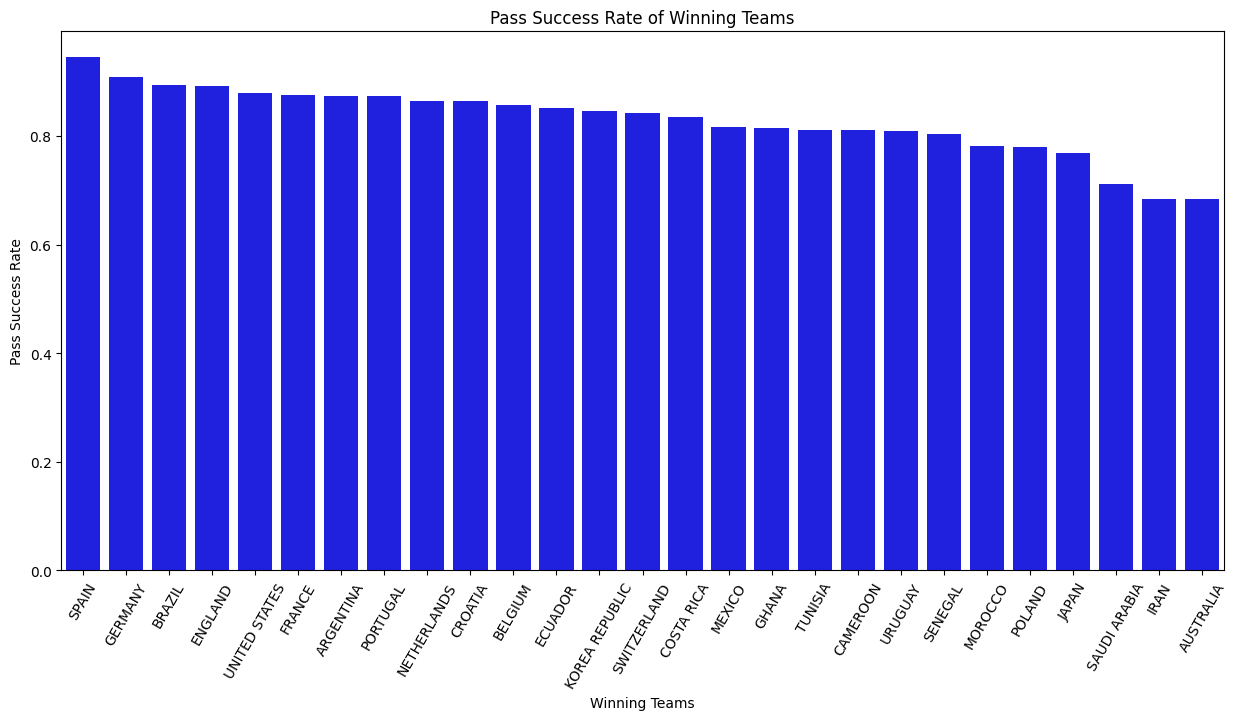

In [8]:
#compare the success rate of the passes of the winning team with the losing team
#compare the success rate of the passes of each round 

clean_df["1_pass_success"] = clean_df["1_passes_compeletd"] / clean_df["1_passes"] 
clean_df["2_pass_success"] = clean_df["2_passes_compeletd"] / clean_df["2_passes"] 


#defining and performing questions 
def winning_team_pass_success(row):
    """
    Calculate the pass success rate of the winning team for a given  match.
    
    Parameters:
    - row: A row from clean_df containing the columns 'Result', 
      '1_pass_success', and '2_pass_success', representing the result of the match 
      and pass success rates of teams 1 and 2, respectively.
    
    Returns:
    - float: The pass success rate of the winning team. It can be one of:
      - Team 1's pass success rate, if team 1 wins.
      - Team 2's pass success rate, if team 2 wins.
      - None, if the match is a tie."""
    
    if row['Result'] == row['1']:
        return row['1_pass_success']
    elif row['Result'] == row['2']:
        return row['2_pass_success']
    else:  # For draws
        return None

clean_df['winning_pass_success'] = clean_df.apply(winning_team_pass_success, axis=1)

# Drop rows with NaN values in the winning_pass_success column
df1 = clean_df.dropna(subset=['winning_pass_success'])

# Group by 'Result' and calculate the mean of 'winning_pass_success'
df1 = duckdb.sql("""SELECT Result, AVG(winning_pass_success) AS winning_pass_success
                    FROM df1
                    GROUP BY Result
                    ORDER BY winning_pass_success DESC;
                    """).df()

# Plot the data
plt.figure(figsize=(15, 7))
sns.barplot(data=df1, x="Result", y="winning_pass_success", color="b", ci=None)
plt.xticks(rotation=60)
plt.title('Pass Success Rate of Winning Teams')
plt.ylabel('Pass Success Rate')
plt.xlabel('Winning Teams')
plt.show()

### 4: Teams' Goal Performance vs. Expected Goals

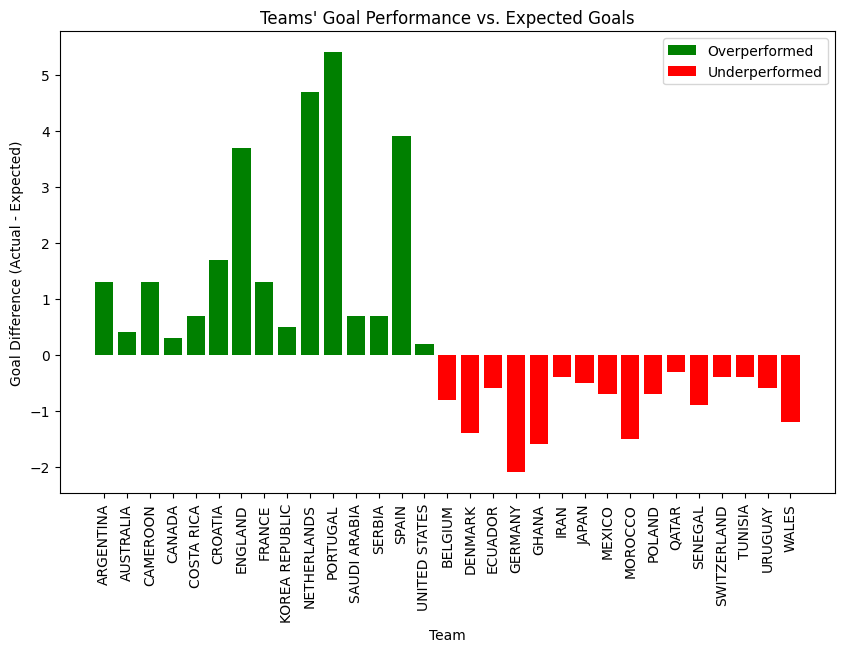

,match_no,date,venue,group,match,1,2,attendance,1_xg,2_xg,...,1_own_goal,2_own_goal,1_defensive_pressure_applied,2_defensive_pressure_applied,Result,1_pass_success,2_pass_success,winning_pass_success,Team_1_Goals_Diff,Team_2_Goals_Diff
0,1,20-Nov-22,Al Bayt Stadium,Group A,QATAR vs ECUADOR,QATAR,ECUADOR,67372,0.3,1.2,...,0,0,256,279,ECUADOR,0.846667,0.852083,0.852083,-0.3,0.8
1,2,21-Nov-22,Khalifa International Stadium,Group B,ENGLAND vs IRAN,ENGLAND,IRAN,45334,2.1,1.4,...,0,0,139,416,ENGLAND,0.902349,0.687500,0.902349,3.9,0.6
2,3,21-Nov-22,Al Thumama Stadium,Group A,SENEGAL vs NETHERLANDS,SENEGAL,NETHERLANDS,41721,0.9,0.7,...,0,0,263,251,NETHERLANDS,0.817232,0.853881,0.853881,-0.9,1.3
3,4,21-Nov-22,Ahmed bin Ali Stadium,Group B,UNITED STATES vs WALES,UNITED STATES,WALES,43418,0.8,1.5,...,0,0,242,292,Draw,0.894552,0.784841,NaN,0.2,-0.5
4,5,22-Nov-22,Lusail Iconic Stadium,Group C,ARGENTINA vs SAUDI ARABIA,ARGENTINA,SAUDI ARABIA,88012,2.2,0.1,...,0,0,163,361,SAUDI ARABIA,0.867213,0.711610,0.711610,-1.2,1.9


In [9]:
clean_df["Team_1_Goals_Diff"] = clean_df["1_goals"] - clean_df["1_xg"]
clean_df["Team_2_Goals_Diff"] = clean_df["2_goals"] - clean_df["2_xg"]

# Calculate the total overperformance or underperformance for each team
team_1_overperformance = clean_df.groupby("1")["Team_1_Goals_Diff"].sum()
team_2_overperformance = clean_df.groupby("2")["Team_2_Goals_Diff"].sum()

# Identify the teams that have overperformed or underperformed
overperforming_teams = team_1_overperformance[team_1_overperformance > 0].index
underperforming_teams = team_1_overperformance[team_1_overperformance < 0].index

# bar plot to visualize overperforming and underperforming teams
plt.figure(figsize=(10, 6))
plt.bar(overperforming_teams, team_1_overperformance[overperforming_teams], label="Overperformed", color="green")
plt.bar(underperforming_teams, team_1_overperformance[underperforming_teams], label="Underperformed", color="red")
plt.xlabel("Team")
plt.ylabel("Goal Difference (Actual - Expected)")
plt.title("Teams' Goal Performance vs. Expected Goals")
plt.legend()
plt.xticks(rotation=90)
plt.show()

clean_df.head()

### 5: Yellow Cards of all teams

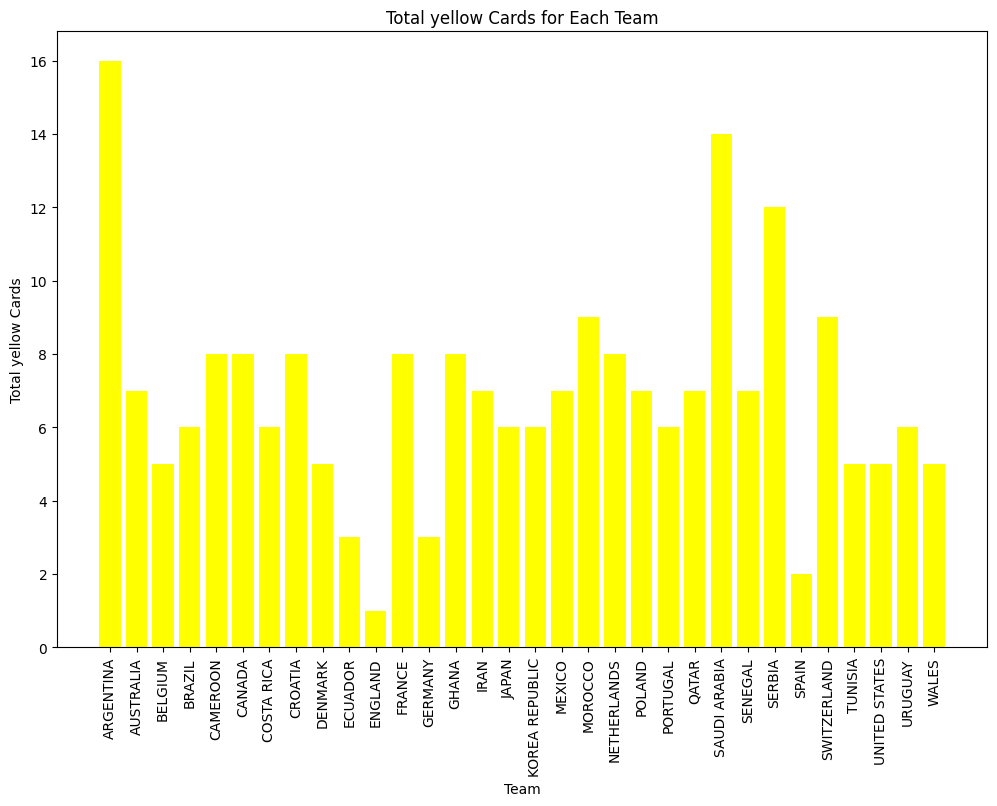

In [10]:
team_1_yellow_cards = clean_df[['1', '1_yellow_cards']]
team_2_yellow_cards = clean_df[['2', '2_yellow_cards']]

# Rename columns to 'Team' and 'yellow_Cards'
team_1_yellow_cards.columns = ['Team', 'yellow_Cards']
team_2_yellow_cards.columns = ['Team', 'yellow_Cards']

# Concatenate the two DataFrames
team_yellow_cards = pd.concat([team_1_yellow_cards, team_2_yellow_cards], ignore_index=True)


total_yellow_cards = team_yellow_cards.groupby('Team')['yellow_Cards'].sum().reset_index()


plt.figure(figsize=(12, 8))
plt.bar(total_yellow_cards['Team'], total_yellow_cards['yellow_Cards'], color='yellow')
plt.xlabel("Team")
plt.ylabel("Total yellow Cards")
plt.title("Total yellow Cards for Each Team")
plt.xticks(rotation=90)

# Show the plot
plt.show()

### 6: Red Cards of all teams

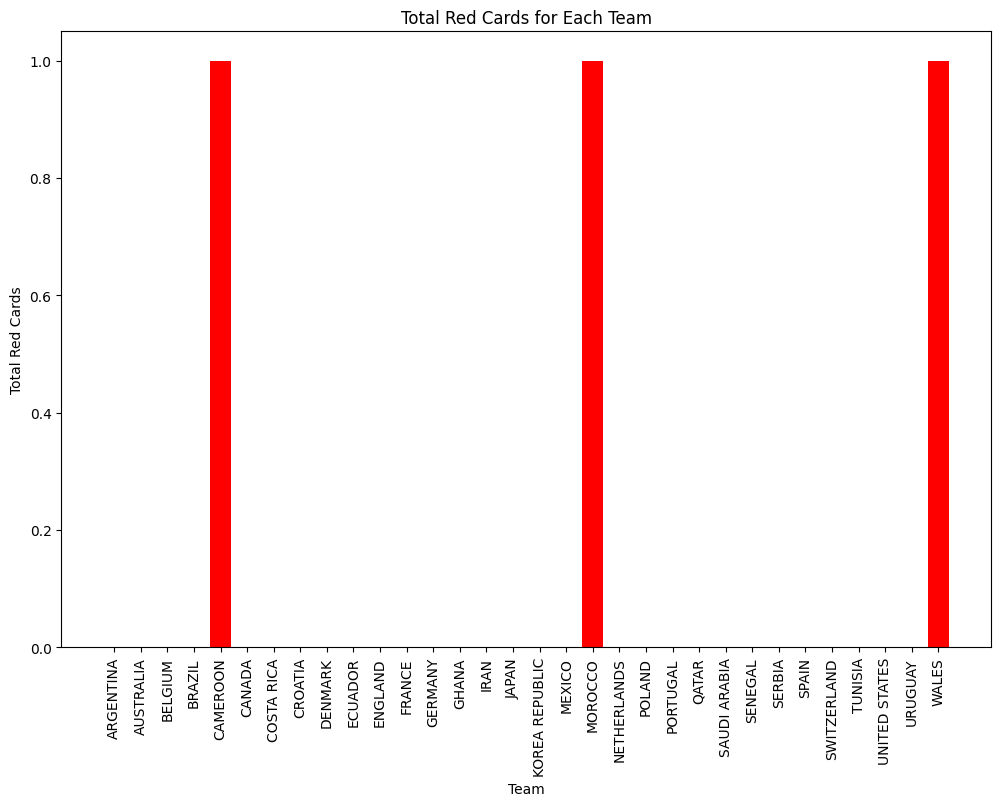

In [11]:
team_1_red_cards = clean_df[['1', '1_red_cards']]
team_2_red_cards = clean_df[['2', '2_red_cards']]

# Rename columns to 'Team' and 'Red_Cards'
team_1_red_cards.columns = ['Team', 'Red_Cards']
team_2_red_cards.columns = ['Team', 'Red_Cards']

# Concatenate the two DataFrames
team_red_cards = pd.concat([team_1_red_cards, team_2_red_cards], ignore_index=True)


total_red_cards = team_red_cards.groupby('Team')['Red_Cards'].sum().reset_index()


plt.figure(figsize=(12, 8))
plt.bar(total_red_cards['Team'], total_red_cards['Red_Cards'], color='red')
plt.xlabel("Team")
plt.ylabel("Total Red Cards")
plt.title("Total Red Cards for Each Team")
plt.xticks(rotation=90)

# Show the plot
plt.show()

### 7: Comparing the successful pass rate and possession of Saudi Arabia and Argentina
Comparing offsides and shots ontarget of Saudi Arabia and Argentina

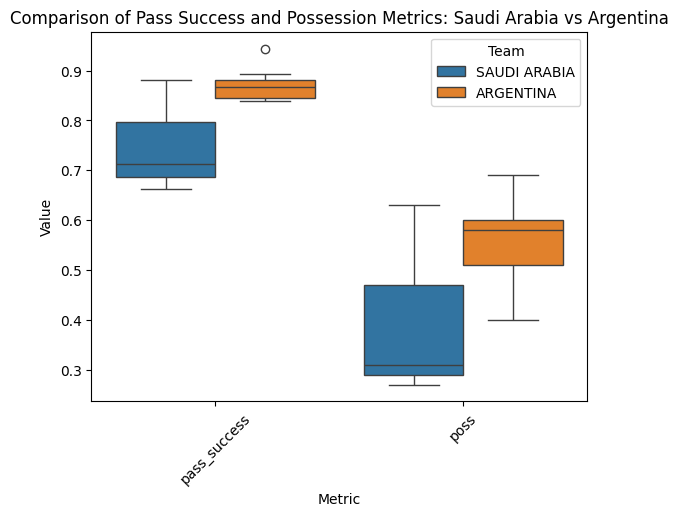

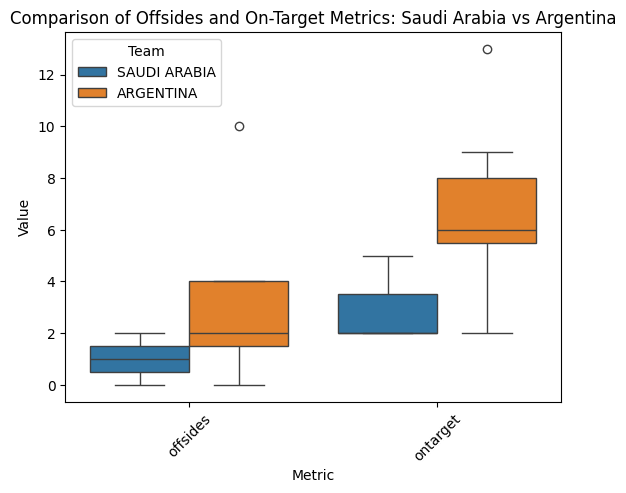

In [12]:
#pick out one game, comparing the average Saudi Arabian performance metrics with 
#their actual performance in the Argentina vs. Saudi Arabia match 

clean_df["1_poss"] = clean_df["1_poss"] / 100 
clean_df["2_poss"] = clean_df["2_poss"] / 100 

# Retrieve metrics for all Saudi Arabia matches
saudi_metrics = duckdb.sql("""
    SELECT
        CASE 
            WHEN "1" = 'SAUDI ARABIA' THEN "1_pass_success"
            WHEN "2" = 'SAUDI ARABIA' THEN "2_pass_success"
        END AS pass_success,
        CASE 
            WHEN "1" = 'SAUDI ARABIA' THEN "1_offsides"
            WHEN "2" = 'SAUDI ARABIA' THEN "2_offsides"
        END AS offsides,
        CASE 
            WHEN "1" = 'SAUDI ARABIA' THEN "1_ontarget"
            WHEN "2" = 'SAUDI ARABIA' THEN "2_ontarget"
        END AS ontarget,
        CASE 
            WHEN "1" = 'SAUDI ARABIA' THEN "1_poss"
            WHEN "2" = 'SAUDI ARABIA' THEN "2_poss"
        END AS poss
    FROM clean_df
    WHERE "1" = 'SAUDI ARABIA' OR "2" = 'SAUDI ARABIA'
""").df()

# Retrieve metrics for all Argentina matches
argentina_metrics = duckdb.sql("""
    SELECT
        CASE 
            WHEN "1" = 'ARGENTINA' THEN "1_pass_success"
            WHEN "2" = 'ARGENTINA' THEN "2_pass_success"
        END AS pass_success,
        CASE 
            WHEN "1" = 'ARGENTINA' THEN "1_offsides"
            WHEN "2" = 'ARGENTINA' THEN "2_offsides"
        END AS offsides,
        CASE 
            WHEN "1" = 'ARGENTINA' THEN "1_ontarget"
            WHEN "2" = 'ARGENTINA' THEN "2_ontarget"
        END AS ontarget,
        CASE 
            WHEN "1" = 'ARGENTINA' THEN "1_poss"
            WHEN "2" = 'ARGENTINA' THEN "2_poss"
        END AS poss
    FROM clean_df
    WHERE "1" = 'ARGENTINA' OR "2" = 'ARGENTINA'
""").df()

# Add a 'team' column to distinguish between Saudi Arabia and Argentina metrics
saudi_metrics['team'] = 'SAUDI ARABIA'
argentina_metrics['team'] = 'ARGENTINA'

# Concatenate the two dataframes
combined_df = pd.concat([saudi_metrics, argentina_metrics])

# Melt the dataframe for box plots
melted_df = pd.melt(combined_df, id_vars=['team'], value_vars=['pass_success', 'poss', 'offsides', 'ontarget'], 
                    var_name='metric', value_name='value')

# Possession and Pass Success Metrics
poss_pass_df = melted_df[melted_df['metric'].isin(['pass_success', 'poss'])]

# Offsides and On-target Metrics
offsides_ontarget_df = melted_df[melted_df['metric'].isin(['offsides', 'ontarget'])]

# Plotting
# First boxplot for pass_success and poss
sns.boxplot(data=poss_pass_df, x='metric', y='value', hue='team')
plt.title('Comparison of Pass Success and Possession Metrics: Saudi Arabia vs Argentina')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.legend(title='Team')
plt.xticks(rotation=45)
plt.show()

# Second boxplot for offsides and on-target
sns.boxplot(data=offsides_ontarget_df, x='metric', y='value', hue='team')
plt.title('Comparison of Offsides and On-Target Metrics: Saudi Arabia vs Argentina')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.legend(title='Team')
plt.xticks(rotation=45)
plt.show()

In [13]:
clean_df.to_csv('clean_df.csv', index=False)

### b. Research question models & testing 

### Hypothesis 1 Analysis

Our logistic regression analysis focused on whether football match outcomes could be predicted using team possession statistics ('1_poss' and '2_poss'). The model yielded an accuracy of 35%, precision of 33%, recall of 86%, and an F1 score of 48%.

These results suggest that possession alone is a weak predictor of match outcomes. The low accuracy and precision indicate limited predictive power, while the high recall shows a tendency to over-predict one class (likely wins for Team 1). The moderate F1 score reflects an imbalance in the model's ability to accurately predict and reliably recall outcomes.

Overall, the analysis reveals the limitations of using possession percentages as sole indicators for predicting football match results. It points towards the need for more comprehensive models that incorporate a wider range of factors beyond simple possession metrics.


In [14]:
data=clean_df

# Dropping rows where the match result was a draw
data_no_draws = data[data['Result'] != 'Draw']

# Encoding the 'Result' as binary (1 for Team 1 win, 0 otherwise)
data_no_draws['Result_encoded'] = (data_no_draws['Result'] == data_no_draws['1']).astype(int)

# Using '1_pass_success' and '2_pass_success' as proxies for possession statistics
X = data_no_draws[['1_pass_success', '2_pass_success']]
y = data_no_draws['Result_encoded']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2950)

# Fitting the logistic regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = log_reg_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
coefficients = log_reg_model.coef_[0]

# Calculating odds ratios for the coefficients
odds_ratio_1_pass_success = np.exp(coefficients[0])
odds_ratio_2_pass_success = np.exp(coefficients[1])

# Displaying the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Coefficient for '1_poss': {coefficients[0]:.4f}")
print(f"Coefficient for '2_poss': {coefficients[1]:.4f}")
print(f"Odds ratio for '1_poss': {odds_ratio_1_pass_success:.2f}")
print(f"Odds ratio for '2_poss': {odds_ratio_2_pass_success:.2f}")

Accuracy: 0.59
Precision: 0.59
Recall: 1.00
F1 Score: 0.74
Coefficient for '1_poss': 0.0558
Coefficient for '2_poss': 0.1899
Odds ratio for '1_poss': 1.06
Odds ratio for '2_poss': 1.21


/var/folders/ws/g1v9kyqj4xx26rv330vt1p7h0000gn/T/ipykernel_60799/3939351578.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_draws['Result_encoded'] = (data_no_draws['Result'] == data_no_draws['1']).astype(int)


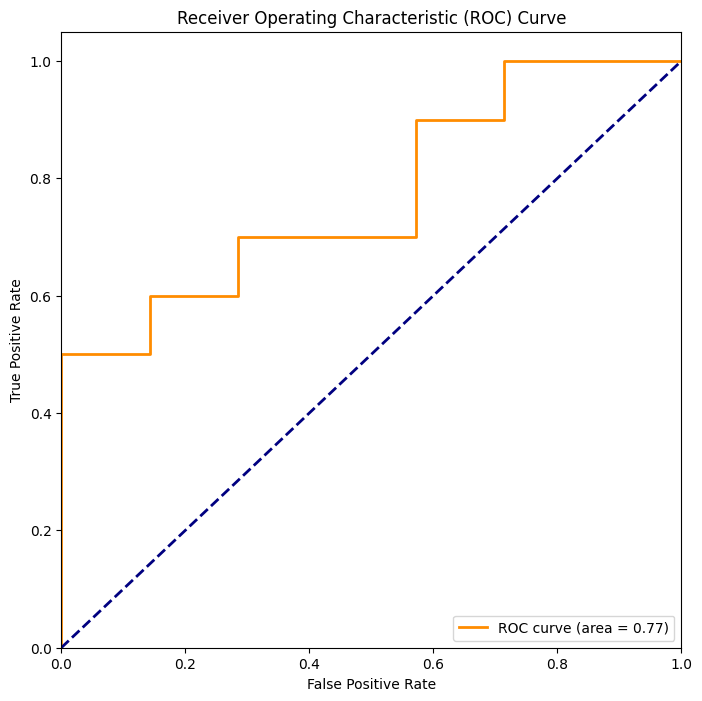

In [16]:
from sklearn.metrics import roc_curve, auc

y_prob = log_reg_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Evaluation of Significance 

**Interpretation of the relationship between '1_poss', '2_poss' and 'Result'**
Our model estimates that, all else equal, for each percentage point increase in Team 1's pass success rate ('1_poss'), the odds of Team 1 winning are multiplied by 1.06 (or an increase of 6% in odds). This suggests that better pass success for Team 1 has a positive but modest impact on their chances of winning, which aligns with the general understanding that effective possession can contribute to better match outcomes.

Our model also estimates that, all else equal, for each percentage point increase in Team 2's pass success rate ('2_poss'), the odds of Team 1 winning are multiplied by 1.21 (or an increase of 21% in odds). This counterintuitive finding implies that higher pass success rates for Team 2 might also increase Team 1's chances of winning, indicating a more nuanced or complex relationship between pass success rates and match outcomes than initially hypothesized.

### Hypothesis 2 Analysis

- **Null Hypothesis**: There is no difference in the combined xG between group stage and knockout stage matches.
- **Alternative Hypothesis**: There is a difference in the combined xG between group stage and knockout stage matches.

### Evaluation of Significance 

In the OLS regression results:

- The **Adjusted R-squared** is **0.001**, indicating that the model explains only 0.1% of the variance in the combined expected goals (xG), which is extremely low.
- The **F-statistic** is **1.032**, and the corresponding **p-value** is **0.314**. 


The high p-value (0.314) associated with the F-statistic indicates that the results are not statistically significant at 0.05 alpha level. This means we do not have sufficient evidence to reject the null hypothesis. In other words, the analysis does not support the alternative hypothesis that knockout stage matches have a higher average xG compared to group stage matches. Instead, it suggests that the stage of the match (group vs. knockout) does not significantly influence the combined xG, implying similar levels of attacking play in both stages of the tournament.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

data = clean_df
data['Stage_Type'] = data['group'].apply(lambda x: 0 if 'Group' in x else 1)

# The dependent variable is the combined xG
data['Combined_xG'] = data['1_xg'] + data['2_xg']

# Fit an OLS model
model = sm.OLS(data['Combined_xG'], sm.add_constant(data['Stage_Type']))
results = model.fit()

# Print the summary table
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Combined_xG   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.032
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.314
Time:                        14:56:29   Log-Likelihood:                -97.979
No. Observations:                  64   AIC:                             200.0
Df Residuals:                      62   BIC:                             204.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5667      0.164     15.648      0.0

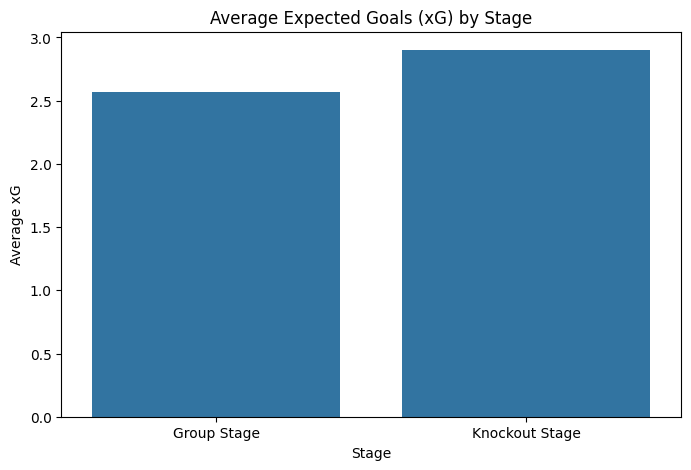

In [15]:
# Data preparation
clean_df['Stage_Type'] = clean_df['group'].apply(lambda x: 0 if 'Group' in x else 1)
clean_df['Combined_xG'] = clean_df['1_xg'] + clean_df['2_xg']

# Calculating average xG for group and knockout stages
avg_xg_group = clean_df[clean_df['Stage_Type'] == 0]['Combined_xG'].mean()
avg_xg_knockout = clean_df[clean_df['Stage_Type'] == 1]['Combined_xG'].mean()
avg_xg = [avg_xg_group, avg_xg_knockout]

# Defining stages for visualization
stages = ['Group Stage', 'Knockout Stage']

# Visualization - Bar Plot of Average xG
plt.figure(figsize=(8, 5))
sns.barplot(x=stages, y=avg_xg)
plt.title('Average Expected Goals (xG) by Stage')
plt.ylabel('Average xG')
plt.xlabel('Stage')
plt.show()

**Bar Plot Interpretation**:
The bar plot displays the average expected goals (xG) for the group and knockout stages of the tournament, with the group stage shown in blue and the knockout stage in orange. While the average xG for the knockout stage appears slightly higher than for the group stage, the difference is not huge. The height of each bar corresponds to the mean xG value, allowing for a straightforward comparison. This visual suggests that while there might be a trend towards higher xG in the knockout stages, the difference is not large enough to draw definitive conclusions about the aggressiveness of play without more analysis.

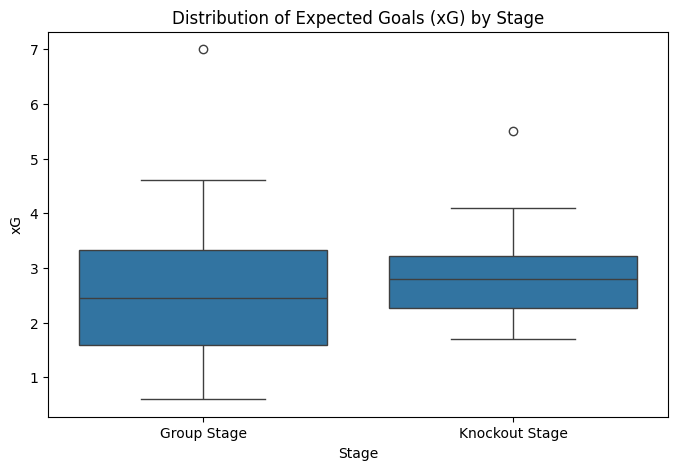

In [16]:
# Preparing data for Box Plot visualization
group_stage = clean_df[clean_df['Stage_Type'] == 0]
knockout_stage = clean_df[clean_df['Stage_Type'] == 1]

# Creating combined xG for both stages
combined_xg = pd.concat([group_stage['Combined_xG'], knockout_stage['Combined_xG']])
stage_labels = ['Group Stage'] * len(group_stage) + ['Knockout Stage'] * len(knockout_stage)

# Visualization - Box Plot of xG Values
plt.figure(figsize=(8, 5))
sns.boxplot(x=stage_labels, y=combined_xg)
plt.title('Distribution of Expected Goals (xG) by Stage')
plt.ylabel('xG')
plt.xlabel('Stage')
plt.show()

**Box Plot Interpretation**:
The box plot illustrates the distribution of expected goals (xG) across group and knockout stages. The central line in each box indicates the median xG, and the box length represents the interquartile range (IQR), which shows the middle 50% of scores for each stage. Both stages show a similar median value, but the knockout stage displays a slightly wider IQR, suggesting more variability in the xG values. Outliers are present in both stages, indicated by diamonds, reflecting matches with exceptionally high xG values that fall outside the typical range. The similarity in the spread and central tendency between the two stages implies that the overall attacking intensity, as measured by xG, is quite consistent across the stages.

# 5: Data Limitations

- The data lacks comprehensive coverage of a game or season, with notable omissions such as injury reports, player transfers, and off-field events. These omissions can significantly impact the accuracy of analysis.

- The data might exhibit bias stemming from factors like home-field advantage, referee decisions, or player behavior, potentially distorting the interpretation of results.

- Certain events, like fouls and bookings (yellow and red cards), hinge on subjective referee decisions, introducing potential bias into the dataset.

- The games may have been influenced by unaccounted factors such as weather conditions, pitch quality, and crowd atmosphere, which, despite their significant impact on the game, are often missing from the datasets.

- National teams participating in the World Cup can display varying levels of talent and experience, creating fluctuations in the strength of competition from match to match. Considering this context is crucial for proper analysis.

### Specific World Cup Considerations

- The knockout stages of the World Cup introduce single-elimination matches, increasing the unpredictability of outcomes.

- Qatar's potential home-field advantage could sway results.

- The World Cup's four-year cycle and the relatively limited number of matches may lead to increased variability in statistics due to smaller sample sizes.


# 6: Sources used 

* https://matplotlib.org/stable/users/index.html
* https://matplotlib.org/stable/tutorials/index.html
* https://numpy.org/doc/
* https://seaborn.pydata.org/tutorial.html
* https://duckdb.org/docs/
* https://www.geeksforgeeks.org/numpy-tutorial/
* https://www.datacamp.com/tutorial/seaborn-python-tutorial

# 7: Acknowledge 

- Github: we are very thankful for Shrikrishna Parab for scraping the 2022 FIFA World Cup, in which his introduction can be found here: https://github.com/shreeparab1890/Fifa-WC-2022-Qatar-Data-Analysis-EDA/blob/main/README.md
